In [1]:
import os
os.chdir('/Users/Sinead/DC-project/cleancode')
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
%matplotlib inline
import plotly 
plotly.offline.init_notebook_mode()
import findeyes
import nibabel as nib
import core
import SimpleITK as sitk

In [2]:
path = '/Volumes/SINEADUSB/DC-Project-Images/original/Sample3/S3_Pre-op.nrrd'

In [3]:
if path.endswith('.nii') or path.endswith('.nii.gz'):
    array, ConstPixelSpacing, affine = core.nifti2np(path)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)
    # visual     = core.thresholdnp(self.scan.array, -100, 1500)

elif path.endswith('.dcm'):
    array, ConstPixelSpacing, affine = core.dicom2np(path)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)
    # visual     = core.thresholdnp(self.scan.array, -100, 1500)

elif path.endswith('.nrrd'):
    array, ConstPixelSpacing, affine = core.nrrd2np(path)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)

# Reshaping 

In [4]:
boneReshaped = core.reshape(bone, ConstPixelSpacing)
softtissueReshaped = core.reshape(softtissue, ConstPixelSpacing)

In [5]:
H, edges, histData2 = findeyes.hist3dAll(softtissueReshaped)

In [6]:
reload(findeyes)
firstEyeRange, secondEyeRange, certainty  = findeyes.ranges(H,edges)
c1Reshaped, c2Reshaped = findeyes.coords(histData2, firstEyeRange, secondEyeRange)

Optimization terminated successfully.
         Current function value: -20.128545
         Iterations: 36
         Function evaluations: 72


In [7]:
c1 = np.divide(c1Reshaped, np.array(ConstPixelSpacing))
c2 = np.divide(c2Reshaped, np.array(ConstPixelSpacing))

In [9]:
reload(core)
angs, xcentroids, ycentroids = core.ellipses(boneReshaped)

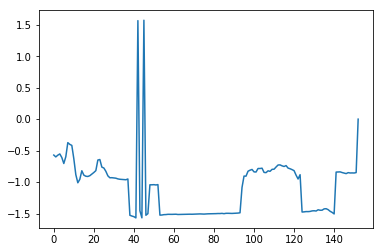

In [10]:
plt.plot(angs)

In [11]:
slices, sliceAngles = core.selectEllipsesRange(angs)
headx = [xcentroids[i] for i in slices] 
heady = [ycentroids[i] for i in slices] 

In [12]:
angle1, angle2 = findeyes.anglesFromEyes(c1Reshaped,c2Reshaped)

In [13]:
type(angle1)

numpy.float64

In [14]:
reload(findeyes)
rotatedBone0, rotatedBone = findeyes.correctSkews(angle1, angle2, boneReshaped)

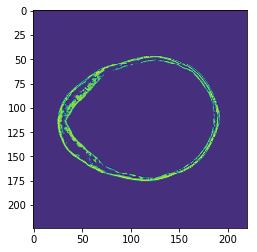

In [15]:
plt.imshow(rotatedBone0[:,:,50])
# plt.imshow(rotatedBone[:,:,50])

In [34]:
reload(core)
a,b,c,d,normal = core.findPlaneFromEllipses(rotatedBone, c1Reshaped, c2Reshaped, slices, headx, heady, sliceAngles)


Using ellipses to find midplane 

[ 111.71700726  115.46760995   72.        ]


In [35]:
core.visualiseSingle(rotatedBone, a,b,c,d, 40)

In [36]:
import numpy as np
import math

def rotationMatrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

theta1 = angle1/360.*2*np.pi
theta2 = angle2/360.*2*np.pi

In [40]:
reload(core)
if abs(angle1) < 45:
    axis = [0,0,1]
    n1 = np.dot(rotationMatrix(axis,theta2*(1.-np.sin(theta1))), normal)
    axis = [0,-1,0]
    normal = np.dot(rotationMatrix(axis,theta1), n1)

elif abs(angle1) > 45:
    axis = [0,0,1]
    n1 = np.dot(rotationMatrix(axis,theta2*(np.sin(theta1))), normal)
    axis = [0,-1,0]
    normal = np.dot(rotationMatrix(axis,np.pi/2.-theta1), n1)

c = 0.5*(c1+c2)
c = np.roll(c,1)
d = np.dot(c,normal)
a = normal[0]
b = normal[1]
c = normal[2]

In [41]:
shape = array.shape
mask = np.zeros((shape))
x = np.arange(0,shape[0],1)
z = np.linspace(0,shape[2],shape[0])

xx, yy = np.meshgrid(z, (d-c*z-a*x)/b)
y = yy.astype(int)

for k in range(shape[1]):
    for i in range(shape[2]):
        mask[y[k][i]-1:y[k][i]+1, k, i] = 1

In [45]:
core.visualiseSingle(array, a,b,c,d,35)

In [42]:
mask = np.swapaxes(mask, 0, 2)

In [43]:
img = sitk.GetImageFromArray(mask)

In [ ]:
img.CopyInformation(sitk.ReadImage(path))

In [ ]:
sitk.WriteImage(img, "test.mhd")

In [ ]:
p = np.nonzero(np.array([0,0,0]))

In [ ]:
len(p[0])

In [ ]:
# img=mha.new(data=mask, size=array.shape, spacing=ConstPixelSpacing, 
#             offset=affine[:,3][:3], data_type='short', 
#             direction_cosines=[1, 0, 0, 0, 1, 0, 0, 0, 1])

img=mha.new(data=mask)

In [ ]:
img=mha.new(input_file='/Volumes/SINEADUSB/DC-Project-Images/original/Sample5/S5_Pre_labels.mha')

In [ ]:
import SimpleItk as sitk

In [ ]:
a,b,c,d = core.findplanefromellipses(boneReshaped, c1Reshaped, c2Reshaped, slices, headx, heady, sliceAngles)


In [ ]:
shape = (rotatedBone).shape
mask = -1000*np.ones((shape))
x = np.arange(0,shape[0],1)
z = np.linspace(0,shape[2],shape[0])

xx, yy = np.meshgrid(z, (d-c*z-a*x)/b)
y = yy.astype(int)

for k in range(shape[1]):
    for i in range(shape[2]):
        mask[y[k][i]-1:y[k][i]+1, k, i] = 1000



# print '\n','Saving midplane mask...','\n'

# img = nib.Nifti1Image(mask, self.scan.affine)

# midplaneMaskPath = os.path.join(os.path.split(self.path)[0], 'midplane.nii.gz')
# nib.save(img, midplaneMaskPath)      

In [ ]:
reload(core)
core.visualiseSingle(rotatedBone, a,b,c,d, 50)

In [ ]:
inv=np.linalg.inv(Irotated)

In [ ]:
img = nib.Nifti1Image(array, affine)
nib.save(img, 'testnrrdaffine.nii.gz')    